## Models 7/24

Sections: Read and clean dataset; Selected EDA; Selected predictive models; PCA and clustering (in progress)

Last updated 7/27.

Note 8/7: In a different notebook, further work has been done on PCA, predictive models, and seasonality.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from pandas.tseries.holiday import USFederalHolidayCalendar

### Read and clean dataset

In [2]:
data2019 = pd.read_csv('2019_RAW_APC_Data.csv.gz')

In [3]:
for col in ['route finish time','route start time','stop arrival time']:
    data2019[col] = pd.to_datetime(data2019[col])

In [4]:
df = data2019

df['Crowded'] = df['passwithin']>74
df['Supercrowded'] = df['passwithin']>134
df['Capacity'] = df['passwithin']>194
df['UnderNeg5'] = df['passwithin']<-5
df['NegAFew'] = df['passwithin'].between(-5,-1)
df['Over250'] = df['passwithin']>250
df['AllObservations'] = True

df['Crowded000'] = df['passwithin']>0
df['Crowded010'] = df['passwithin']>10
df['Crowded020'] = df['passwithin']>20
df['Crowded030'] = df['passwithin']>30
df['Crowded040'] = df['passwithin']>40
df['Crowded050'] = df['passwithin']>50
df['Crowded060'] = df['passwithin']>60
df['Crowded070'] = df['passwithin']>70
df['Crowded080'] = df['passwithin']>80
df['Crowded090'] = df['passwithin']>90
df['Crowded100'] = df['passwithin']>100
df['Crowded110'] = df['passwithin']>110
df['Crowded120'] = df['passwithin']>120
df['Crowded130'] = df['passwithin']>130
df['Crowded140'] = df['passwithin']>140
df['Crowded150'] = df['passwithin']>150
df['Crowded160'] = df['passwithin']>160
df['Crowded170'] = df['passwithin']>170
df['Crowded180'] = df['passwithin']>180
df['Crowded190'] = df['passwithin']>190
df['Crowded200'] = df['passwithin']>200
df['Crowded210'] = df['passwithin']>210
df['Crowded220'] = df['passwithin']>220
df['Crowded230'] = df['passwithin']>230
df['Crowded240'] = df['passwithin']>240

In [5]:
df = data2019

df['TOD'] = df['stop arrival time'].dt.time
df['DOW'] = df['stop arrival time'].dt.dayofweek # 0 is Monday, 6 is Sunday
df['DOW_name'] = df['stop arrival time'].dt.day_name()
df['Date'] = df['stop arrival time'].dt.date
df['Hour'] = df['stop arrival time'].dt.hour
df['Minute'] = df['stop arrival time'].dt.minute
df['Minute_od'] = df['Hour'] * 60 + df['Minute']
df['Month'] = df['stop arrival time'].dt.month
df['Month_name'] = df['stop arrival time'].dt.month_name()
df['Season'] = df['stop arrival time'].dt.quarter
df['DOY'] = df['stop arrival time'].dt.dayofyear

In [6]:
df = data2019

# Create a station ID
# Use a dictionary
names = ['Zero','Angle','SeaTac','Tukwila','Rainier','Othello',
         'Columbia','Baker','Beacon','SODO','Stadium','Intl District',
         'Pioneer','University','Westlake','Capitol Hill ','UW ']

for idx, name in enumerate(names):
    df.loc[df['station name']==name, 'sta_ID'] = idx
    df.loc[df['next station']==name, 'nxsta_ID'] = idx
    
df['sta_ID'] = df['sta_ID'].astype('int32')
df['nxsta_ID'] = df['nxsta_ID'].astype('int32')
df['stadir_ID'] = df['sta_ID'] * 100 + df['nxsta_ID']

In [7]:
# df01 filters out routedones that have >20 stops
rtd = data2019.groupby('routedone').count()['railcar ID']
rtd.name = 'count'
overmuch = rtd[rtd>20]
df01 = data2019[~data2019['routedone'].isin(overmuch.index)]

In [8]:
# df02 is df01 but without >210 observations
df02 = df01[~df01['Crowded210']]

In [9]:
# df03 is df02 but without any against-equation trips

against_calc = pd.read_csv('routes_against_calc.csv').iloc[:,0]

df03 = df02[~df02['routedone'].isin(against_calc)]

In [10]:
# df04 is df03 but without any trips where the train visited stations out of sequence.
# In other words, df04 consists of only normal stadir values.

abnormal = pd.read_csv('abnormal_stadir_routes.csv').iloc[:,0]

df04 = df03[~df03['routedone'].isin(abnormal)]

In [11]:
print(len(df01), len(df02), len(df03), len(df04))

1296415 1295022 1285752 1208360


df04 is our excellent dataset!

## Selected EDA

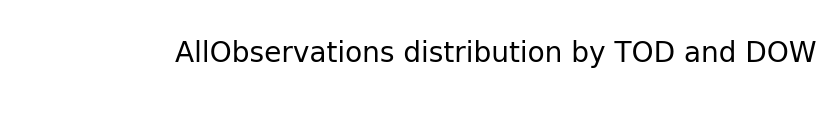

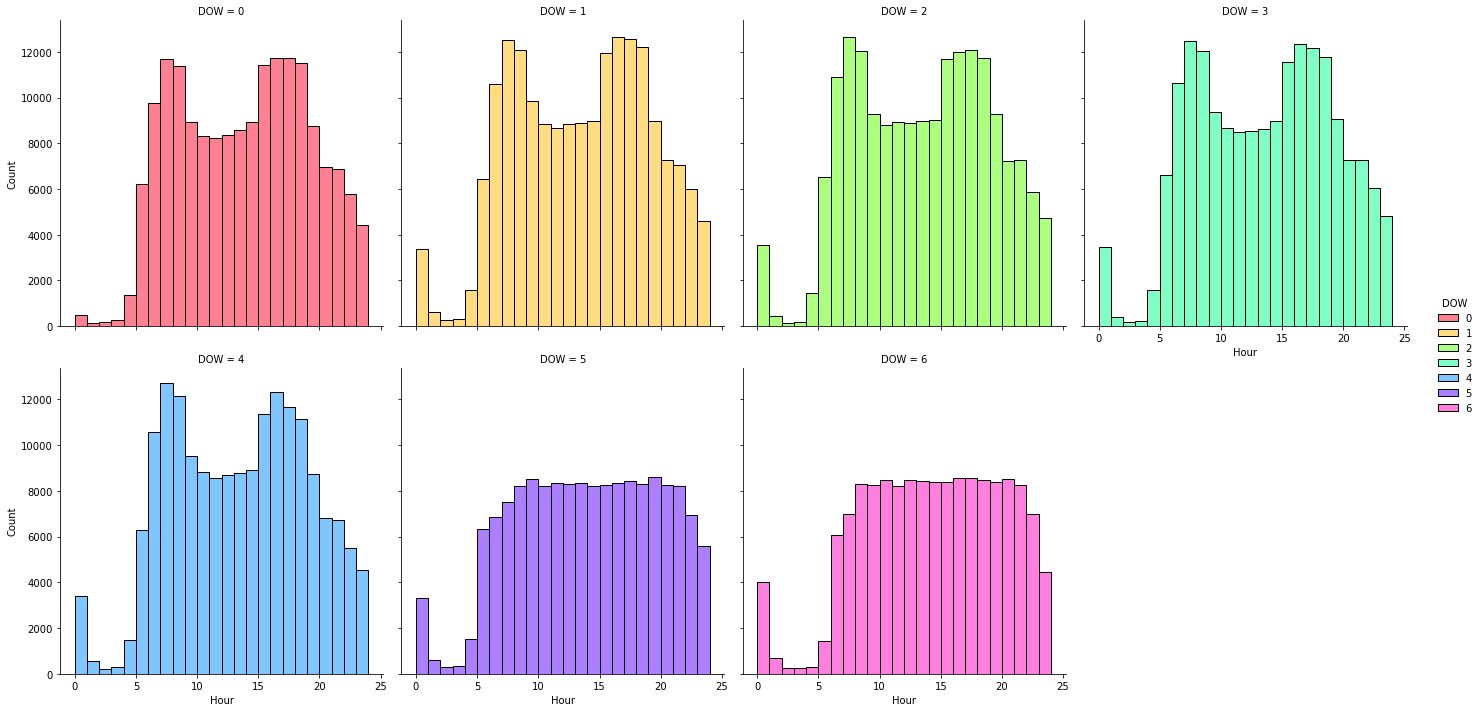

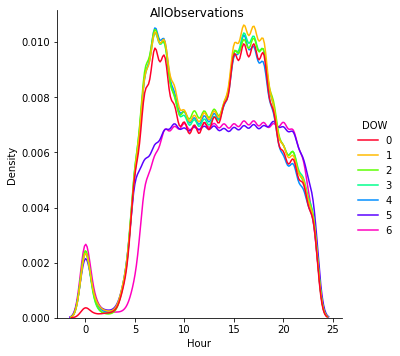

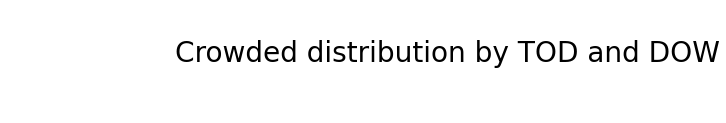

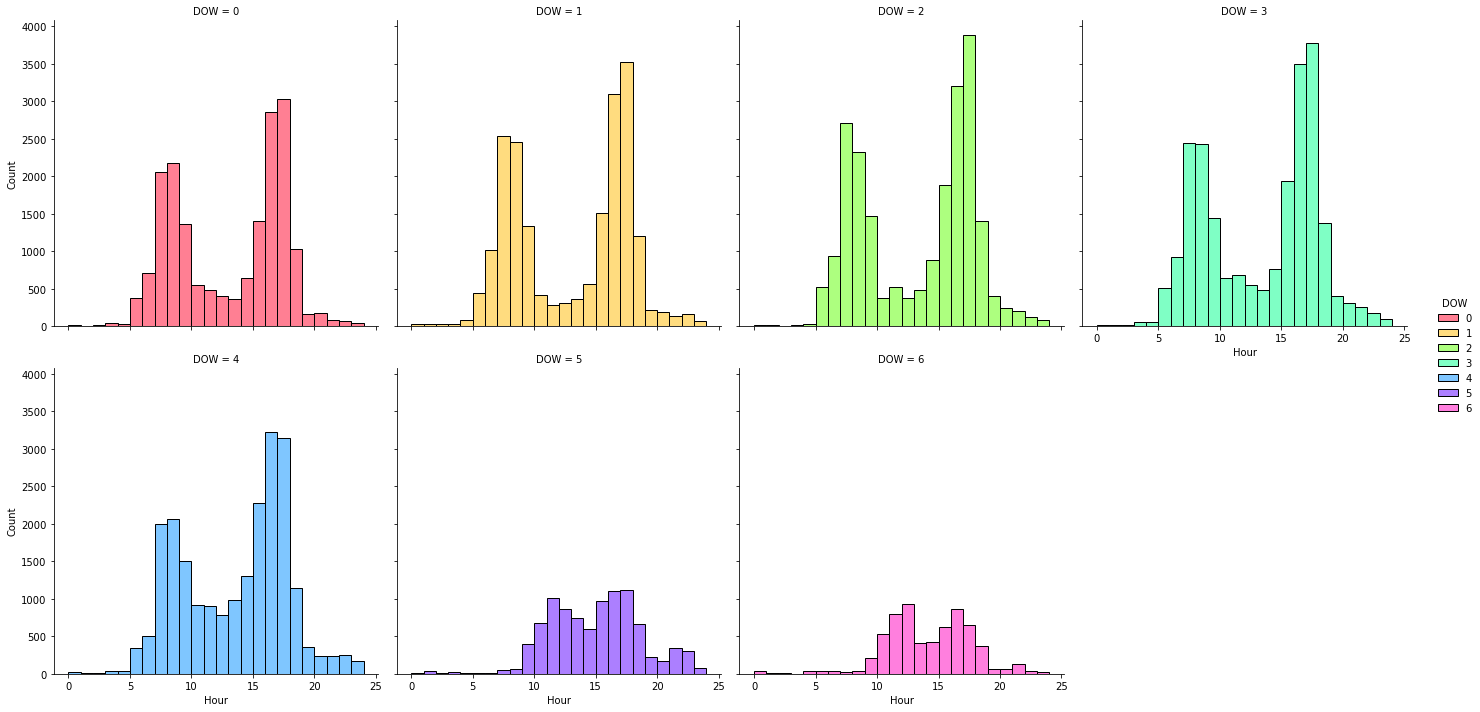

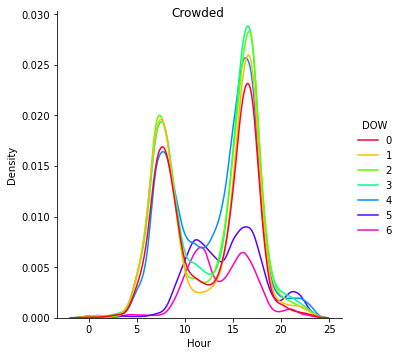

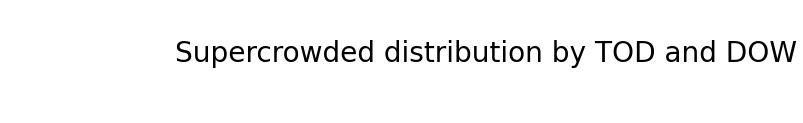

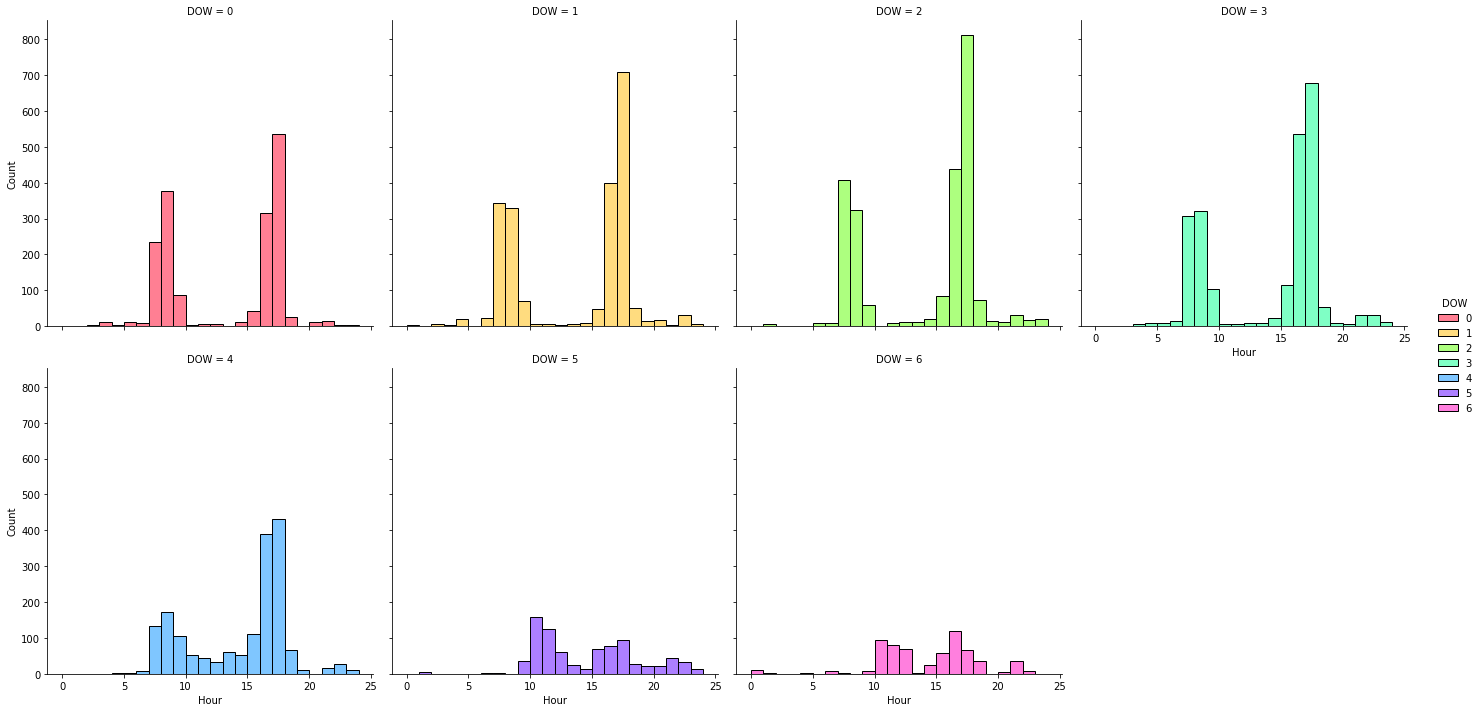

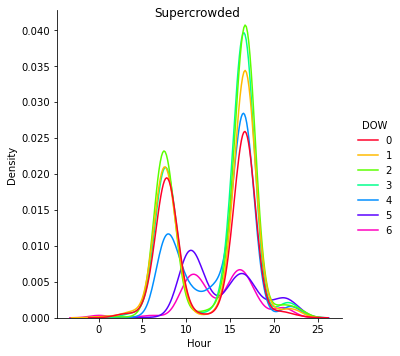

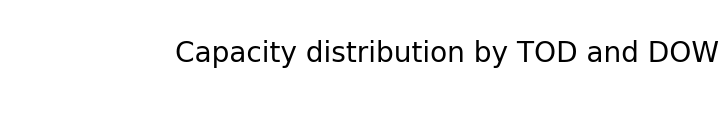

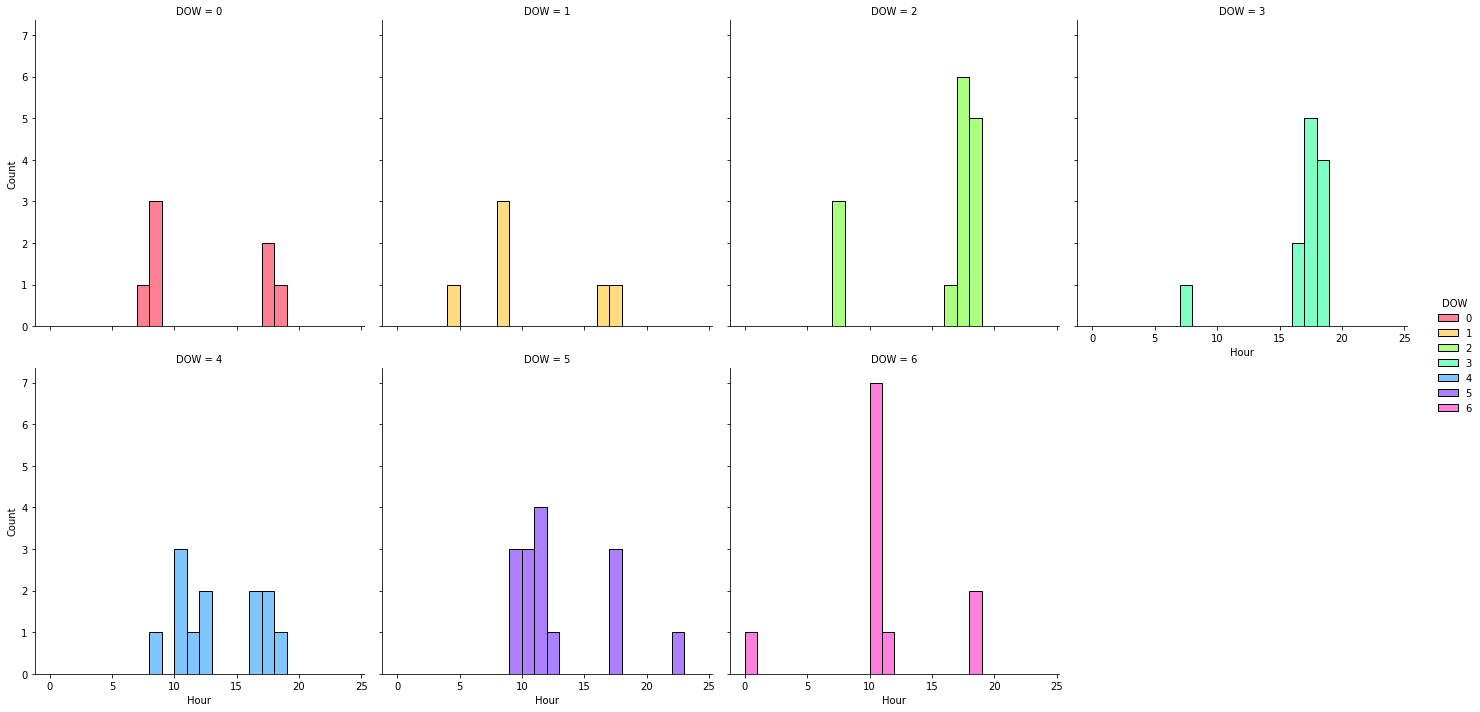

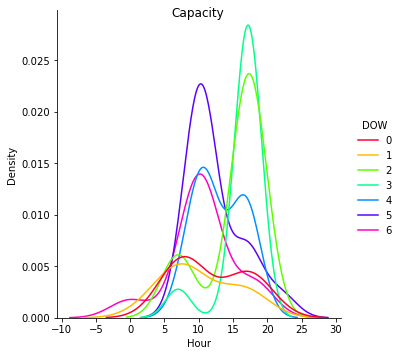

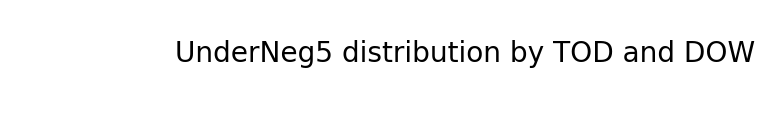

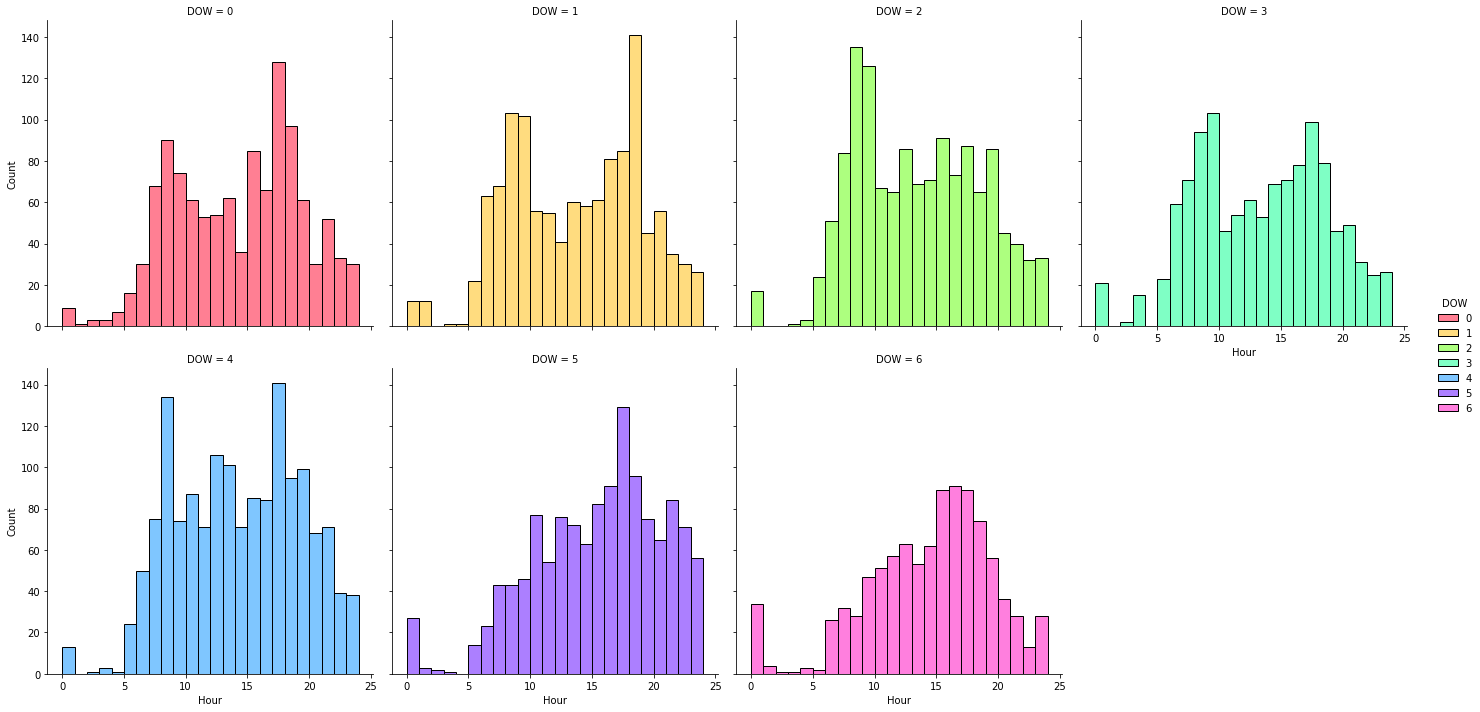

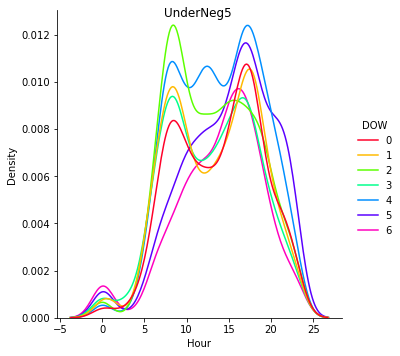

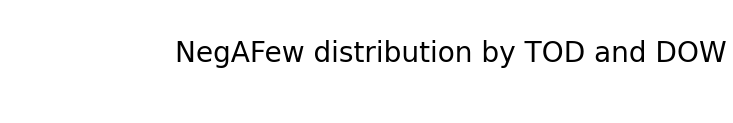

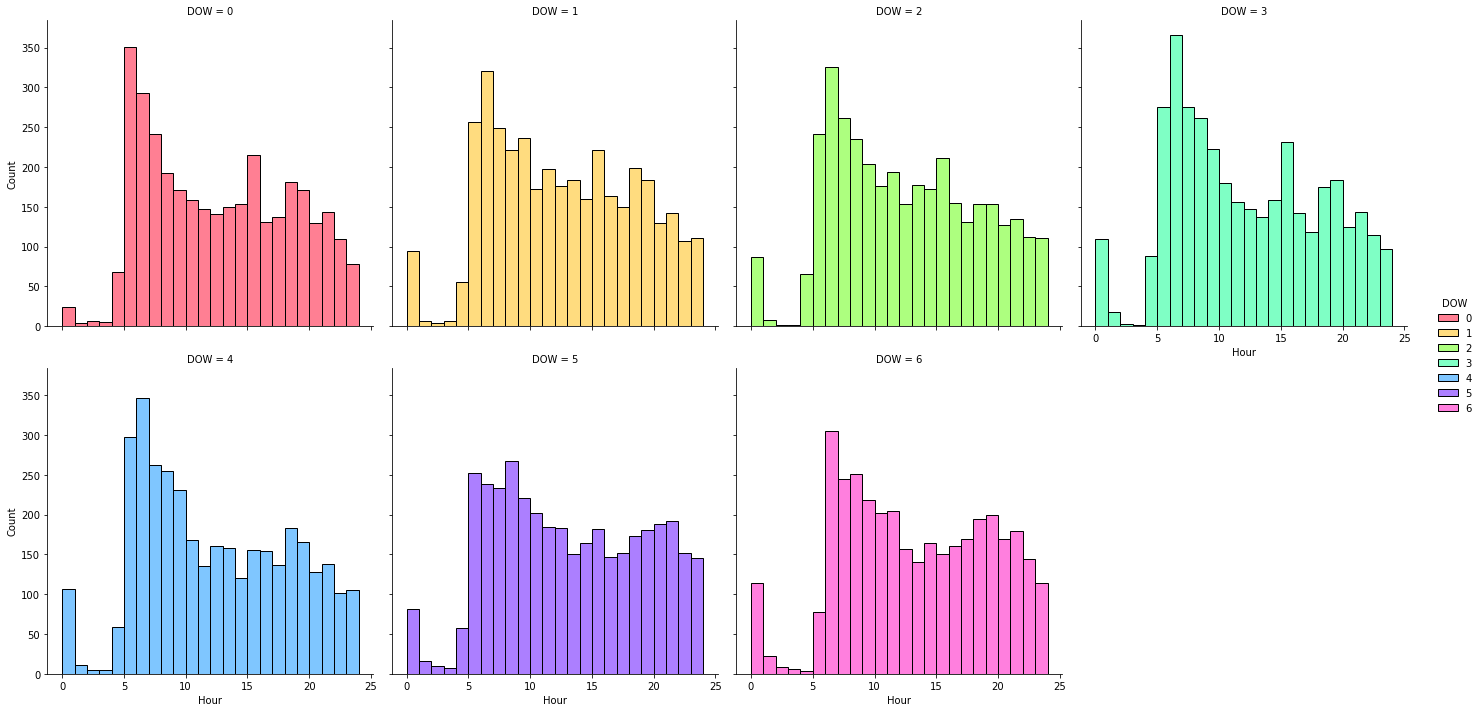

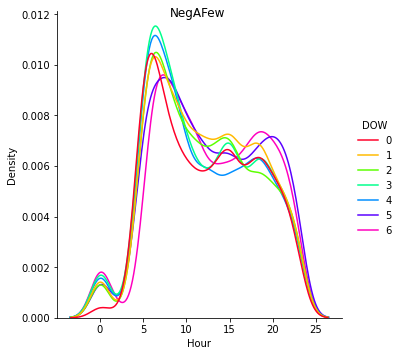

In [12]:
df = df04

ofinterest = ['AllObservations','Crowded','Supercrowded','Capacity','UnderNeg5','NegAFew']

for col in ofinterest:
    plt.subplots(figsize=(6, 2))
    plt.text(0.5, 0.5, col+' distribution by TOD and DOW', fontsize=28)
    plt.axis('off')
    b = sns.displot(x=df.loc[df[col],'Hour'], col=df.loc[df[col],'DOW'],
                binwidth=1, binrange=[0,24], hue=df.loc[df[col],'DOW'], palette='gist_rainbow', col_wrap=4)
    c = sns.displot(x=df.loc[df[col],'Hour'], hue=df.loc[df[col],'DOW'],
                kind='kde', palette='gist_rainbow').fig.suptitle(col)

C:\Users\augus\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


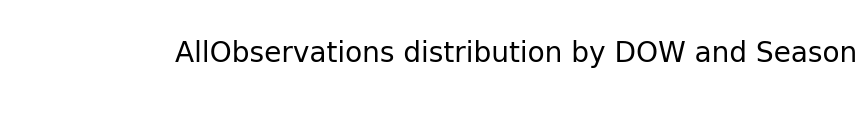

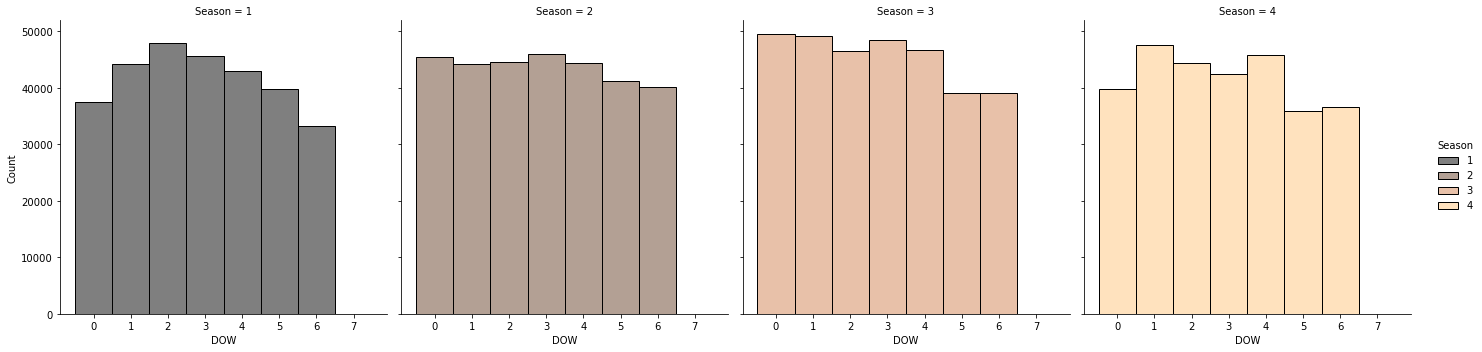

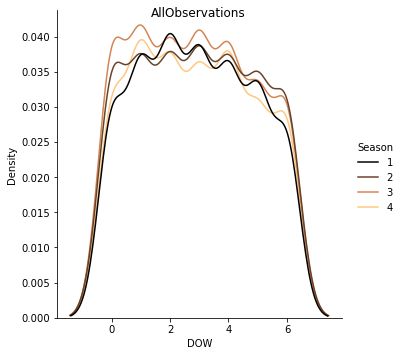

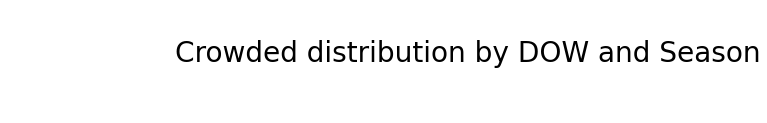

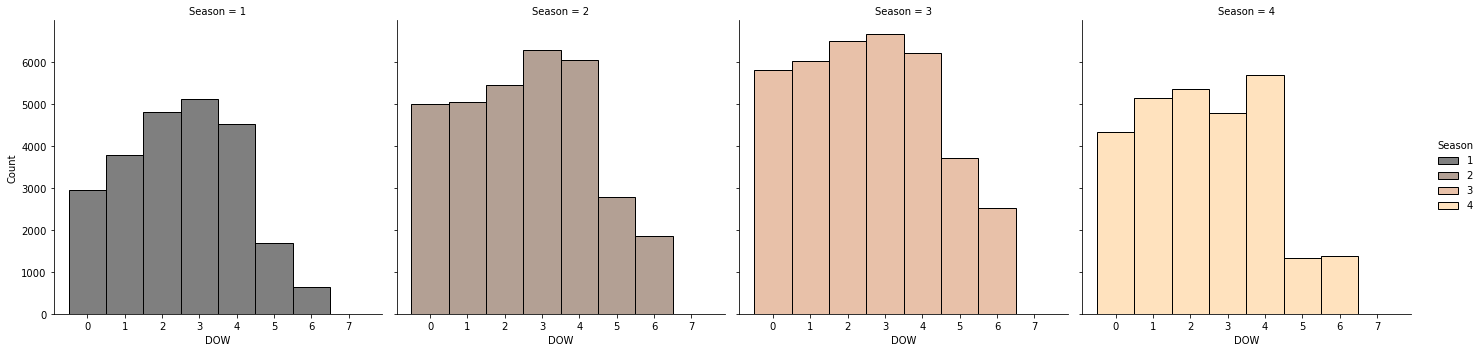

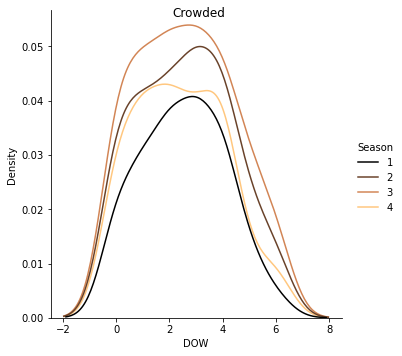

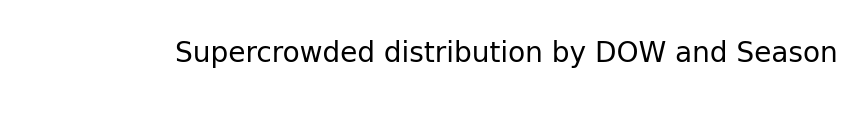

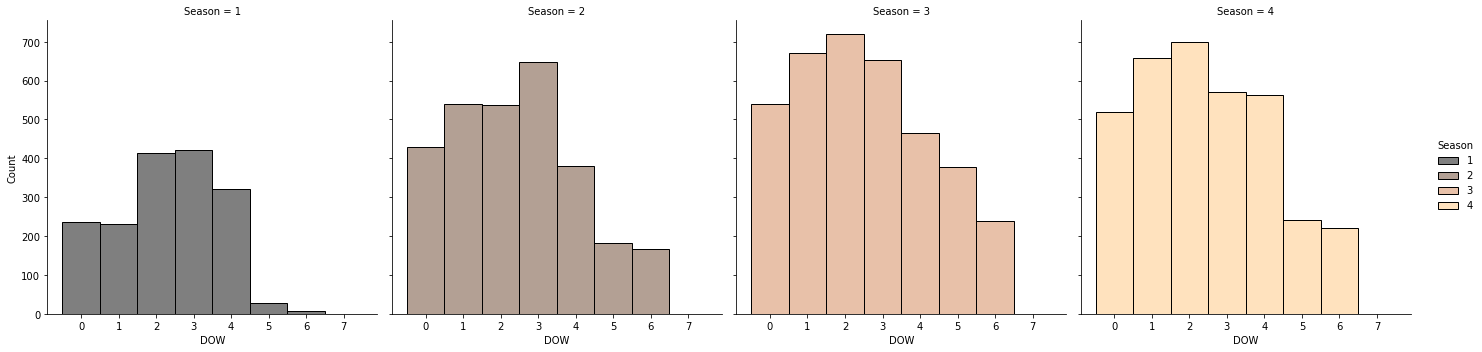

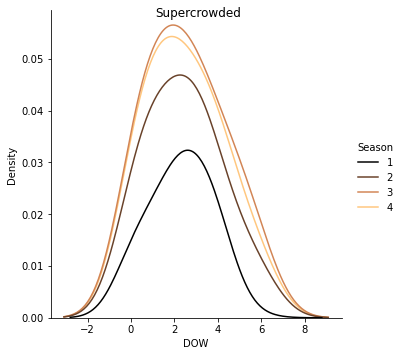

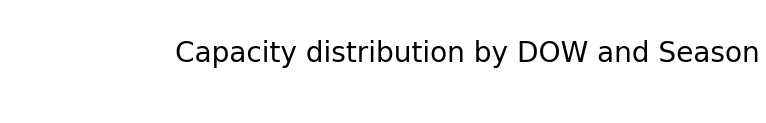

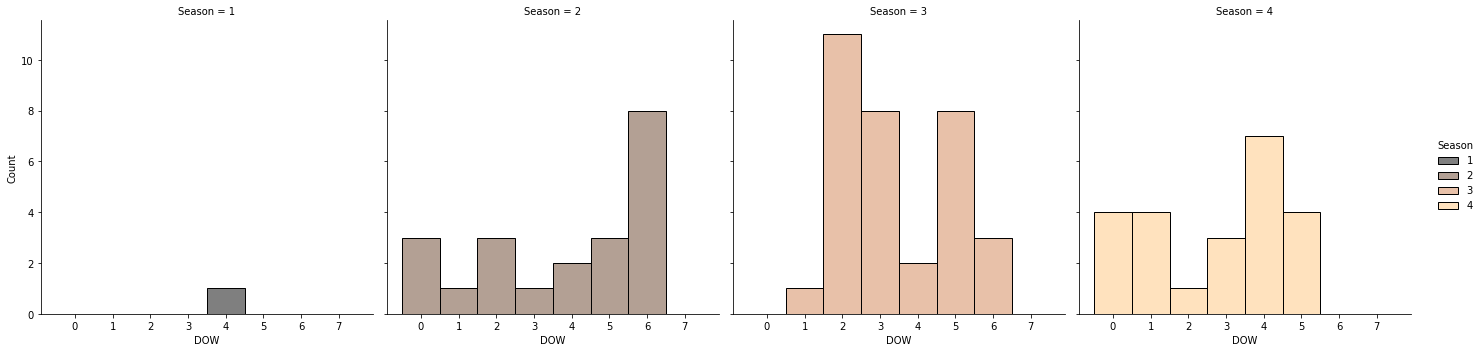

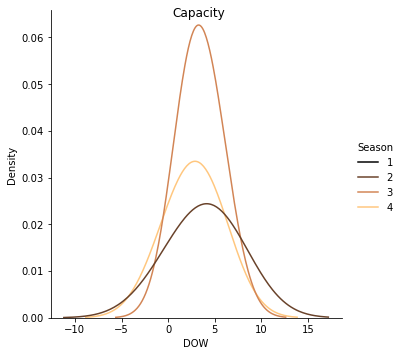

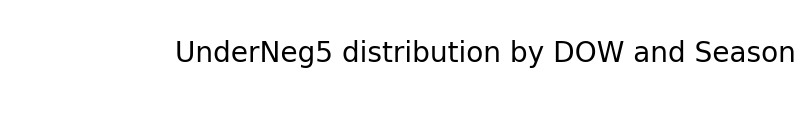

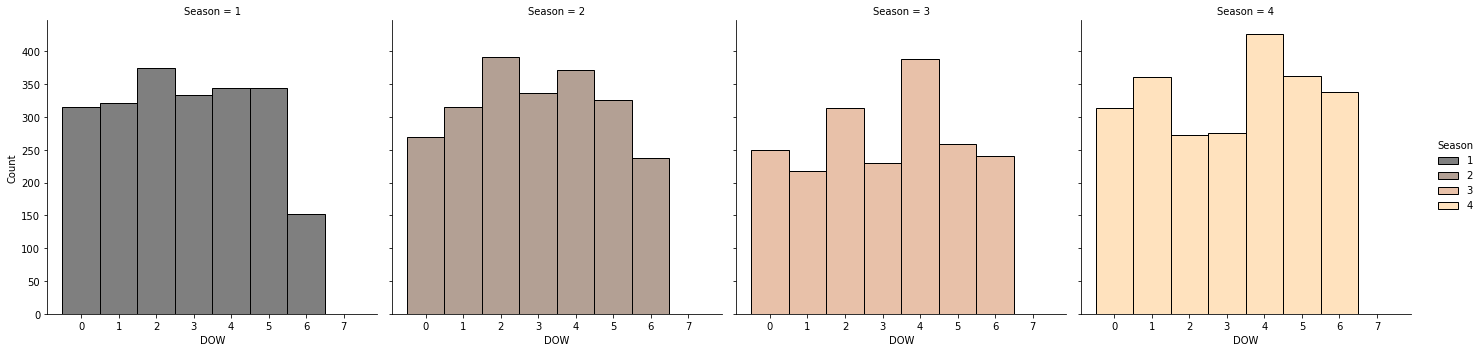

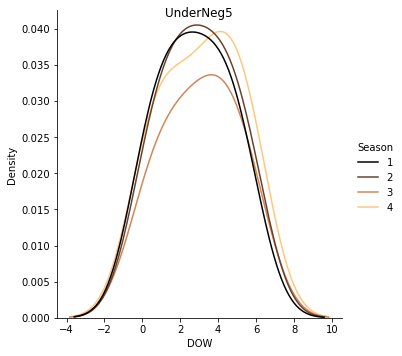

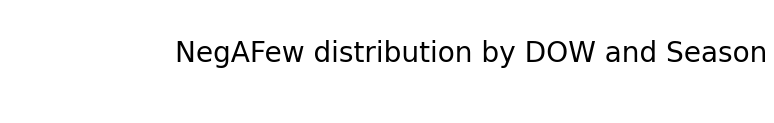

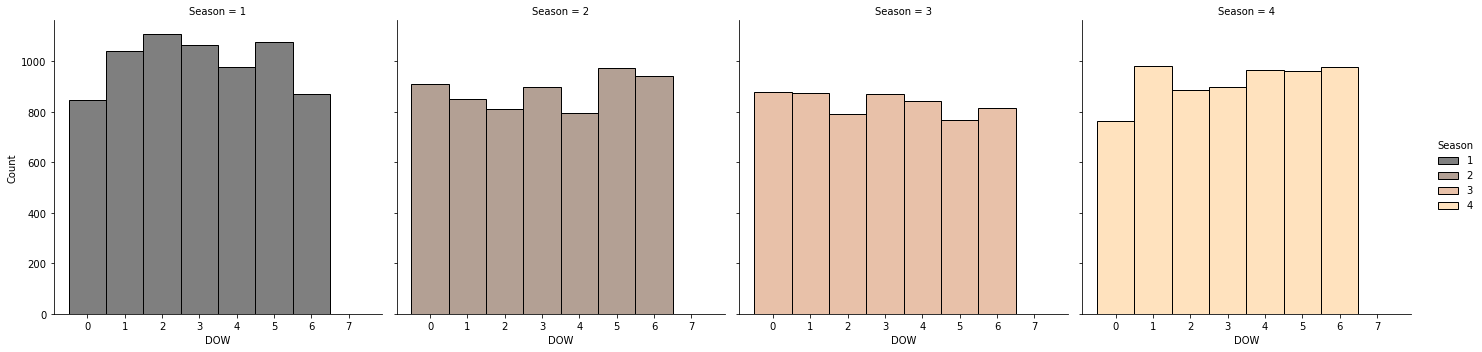

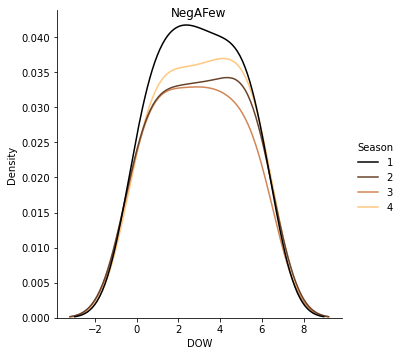

In [13]:
df = df04

ofinterest = ['AllObservations','Crowded','Supercrowded','Capacity','UnderNeg5','NegAFew']

for col in ofinterest:
    plt.subplots(figsize=(6, 2))
    plt.text(0.5, 0.5, col+' distribution by DOW and Season', fontsize=28)
    plt.axis('off')
    b = sns.displot(x=df.loc[df[col],'DOW'], col=df.loc[df[col],'Season'],
                    binwidth=1, binrange=[0,7], hue=df.loc[df[col],'Season'],
                    discrete=True,
                    palette = 'copper',
                    col_wrap=4)
    c = sns.displot(x=df.loc[df[col],'DOW'], hue=df.loc[df[col],'Season'],
                    kind='kde', bw_adjust = 3,
                    palette='copper').fig.suptitle(col)

## Prepare readout functions

In [14]:
# Code adapted from sklearn user guide 3.3.1.4

def all_inclusive_scorer(clf, X, y):
    print('Starting work on a new fold...')
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    pr = precision_score(y, y_pred)
    re = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1],
            'precision': pr,
            'recall': re,
            'f1': f1}

In [15]:
def cv_readout(model, X, y):
    print('Performing 5-fold cross-validation...')
    #scores = cross_validate(model, X, y, cv=5, scoring=['precision','recall','f1','confusion_matrix'])
    raw = cross_validate(model, X, y, cv=5, scoring=all_inclusive_scorer)
    print('Aggregating the scores...')
    sum_cm = np.array([[sum(raw['test_tn']), sum(raw['test_fp'])],
                       [sum(raw['test_fn']), sum(raw['test_tp'])]])
    
    agg_scores = pd.DataFrame(index=['precision','recall','f1'],
                              columns=['mean','std'])
    agg_scores.at['precision','mean'] = np.mean(raw['test_precision'])
    agg_scores.at['precision','std'] = np.std(raw['test_precision'])
    agg_scores.at['recall','mean'] = np.mean(raw['test_recall'])
    agg_scores.at['recall','std'] = np.std(raw['test_recall'])
    agg_scores.at['f1','mean'] = np.mean(raw['test_f1'])
    agg_scores.at['f1','std'] = np.std(raw['test_f1'])
    
    print(sum_cm)
    print(agg_scores)
    

## Current best predictive model

These use one-hot encoding on the features. This is flawed but at least is a surefire way to help the model pick up on nonlinear effects of Hour, DOW, and Month.

In [16]:
feats03 = ['Hour','DOW','Month','station name','next station']

In [17]:
df = df04
feats = feats03

X = df.loc[:,feats]
y = df.loc[:,'Crowded'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=19)

In [18]:
enc = OneHotEncoder()
X_train_b = enc.fit_transform(X_train)

In [19]:
logi08 = LogisticRegression(class_weight='balanced', solver='saga')
scores = cv_readout(logi08,
                    X_train_b,
                    y_train)
scores

Performing 5-fold cross-validation...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...
Aggregating the scores...
[[615806 253598]
 [ 17840  79444]]
               mean       std
precision  0.238541   0.00082
recall     0.816619  0.002812
f1         0.369227  0.001239


Random Forest actually works better in some ways:

In [20]:
enc = OneHotEncoder()
X_train_b_sam = enc.fit_transform(X_train.sample(100000, random_state=19))

In [21]:
y_train_sam = y_train.sample(100000, random_state=19)

forest01 = RandomForestClassifier()
scores = cv_readout(forest01,
                    X_train_b_sam,
                    y_train_sam)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[86520  3439]
 [ 5648  4393]]
               mean       std
precision  0.560951  0.008194
recall     0.437505  0.013231
f1         0.491491  0.009747


Finally, here's Random Forest with `class_weight='balanced'`. It has better recall but worse precision than the first RF.

In [22]:
enc = OneHotEncoder()
X_train_b_sam = enc.fit_transform(X_train.sample(100000, random_state=19))

In [23]:
y_train_sam = y_train.sample(100000, random_state=19)

forest02 = RandomForestClassifier(class_weight='balanced')
scores = cv_readout(forest02,
                    X_train_b_sam,
                    y_train_sam)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[83141  6818]
 [ 4349  5692]]
               mean       std
precision  0.454972   0.00464
recall     0.566874  0.012619
f1          0.50476  0.007243


## Perform PC-Analysis

#### First perform PCA on stations

In [24]:
df04_train, df04_test = train_test_split(df04,
                                         test_size=0.2,
                                         random_state=19)

In [25]:
# Group passwithin by Hour, DOY, and station (stadir_ID). Take the mean
pw_agg = df04_train.groupby(['Hour','DOY','stadir_ID'])['passwithin'].mean()

In [26]:
station_view = pw_agg.reset_index().pivot(index='stadir_ID', columns=['DOY','Hour'])

In [27]:
station_view

passwithin                                                   \
DOY               1    2          3          4     5          6    7     
Hour               0    0          0          0     0          0    0    
stadir_ID                                                                
101         -0.500000  NaN   0.666667   5.285714   2.5  -1.600000 -2.0   
102          0.000000  NaN        NaN        NaN   NaN        NaN  NaN   
201          9.000000  3.0   4.333333   8.600000   7.0   6.400000  NaN   
203          3.500000  NaN        NaN        NaN   NaN   3.000000  NaN   
302          5.000000  NaN   4.333333  10.000000   7.5   8.000000  7.0   
304          1.333333  NaN        NaN        NaN  16.0   3.000000  NaN   
403         19.333333  NaN   7.750000   5.500000  12.0  11.750000  NaN   
405         14.000000  NaN        NaN        NaN  15.0   5.000000  NaN   
504         22.666667  NaN   9.333333   8.333333  10.0  12.666667  NaN   
506         13.000000  NaN  44.000000  34.000000  14.0  12.500000  NaN   
605         19.000000  NaN  11.000000   7.500000  13.0  13.500000  NaN   
607         18.333333  NaN  43.000000  34.000000  22.0  12.000000  NaN   
706         34.400000  NaN  11.000000  13.500000  20.5  27.000000  NaN   
708         13.000000  NaN  47.000000  32.000000  23.0        NaN  NaN   
807         37.600000  NaN   9.000000  10.000000  19.5  15.333333  NaN   
809         13.333333  NaN  47.000000  31.000000  18.0  17.000000  NaN   
908         52.000000  NaN   9.000000  10.333333  26.0  25.000000  NaN   
910         21.000000  NaN  46.000000  31.000000  18.0   4.000000  NaN   
1009        54.250000  NaN   8.500000  10.000000  21.5  19.333333  NaN   
1011        16.400000  NaN  47.000000  31.000000  18.0   7.000000  NaN   
1110        55.000000  NaN   8.000000   3.000000  18.0  19.000000  NaN   
1112        18.400000  NaN  47.000000  28.000000  18.0   6.000000  NaN   
1211        91.666667  NaN   6.500000   6.500000  25.0        NaN  NaN   
1213        18.200000  NaN        NaN  26.000000  15.0  12.500000  NaN   
1312       102.500000  NaN        NaN   8.000000   NaN  23.000000  NaN   
1314        19.000000  NaN  41.000000  25.000000   NaN   9.666667  NaN   
1413       105.666667  NaN        NaN        NaN  17.0  21.000000  NaN   
1415        48.333333  NaN  39.000000  23.000000  22.0   3.500000  NaN   
1514        21.400000  NaN        NaN   4.000000  10.0  15.000000  NaN   
1516        18.666667  NaN  29.000000  17.000000  20.0   3.666667  NaN   
1615         3.428571  NaN        NaN   3.000000  11.0   4.000000  NaN   
1616        -6.166667  3.0  10.500000   1.500000  -5.5   3.000000  3.0   

                                            ...                        \
DOY              8          9          10   ...        356        357   
Hour              0          0          0   ...         23         23   
stadir_ID                                   ...                         
101        -1.000000        NaN   0.000000  ...   0.500000   1.666667   
102              NaN        NaN        NaN  ...        NaN   1.500000   
201         6.666667  11.000000   3.666667  ...  13.000000  15.000000   
203              NaN  11.000000        NaN  ...   7.000000   8.500000   
302        11.000000  12.000000   7.200000  ...  10.250000  11.500000   
304              NaN   7.000000        NaN  ...        NaN  14.000000   
403        10.000000        NaN  10.600000  ...  10.000000  15.500000   
405              NaN   5.000000        NaN  ...        NaN   7.500000   
504        13.500000        NaN  11.000000  ...  14.250000  17.666667   
506              NaN   5.000000        NaN  ...   5.000000  32.000000   
605        12.000000        NaN  10.400000  ...  17.200000        NaN   
607              NaN        NaN        NaN  ...   6.000000  13.000000   
706        11.000000        NaN  12.600000  ...  20.250000  15.000000   
708              NaN        NaN        NaN  ...        NaN  13.666667   
807        13.000000   5.000000 

In [28]:
station_view.isna().sum().sum()

23372

In [29]:
station_view.shape[0] * station_view.shape[1]

256064

About 8% of entries in this matrix are NaN.

In [30]:
# Try filling NaNs with 0
station_view = station_view.fillna(0)
station_view

passwithin                                                   \
DOY               1    2          3          4     5          6    7     
Hour               0    0          0          0     0          0    0    
stadir_ID                                                                
101         -0.500000  0.0   0.666667   5.285714   2.5  -1.600000 -2.0   
102          0.000000  0.0   0.000000   0.000000   0.0   0.000000  0.0   
201          9.000000  3.0   4.333333   8.600000   7.0   6.400000  0.0   
203          3.500000  0.0   0.000000   0.000000   0.0   3.000000  0.0   
302          5.000000  0.0   4.333333  10.000000   7.5   8.000000  7.0   
304          1.333333  0.0   0.000000   0.000000  16.0   3.000000  0.0   
403         19.333333  0.0   7.750000   5.500000  12.0  11.750000  0.0   
405         14.000000  0.0   0.000000   0.000000  15.0   5.000000  0.0   
504         22.666667  0.0   9.333333   8.333333  10.0  12.666667  0.0   
506         13.000000  0.0  44.000000  34.000000  14.0  12.500000  0.0   
605         19.000000  0.0  11.000000   7.500000  13.0  13.500000  0.0   
607         18.333333  0.0  43.000000  34.000000  22.0  12.000000  0.0   
706         34.400000  0.0  11.000000  13.500000  20.5  27.000000  0.0   
708         13.000000  0.0  47.000000  32.000000  23.0   0.000000  0.0   
807         37.600000  0.0   9.000000  10.000000  19.5  15.333333  0.0   
809         13.333333  0.0  47.000000  31.000000  18.0  17.000000  0.0   
908         52.000000  0.0   9.000000  10.333333  26.0  25.000000  0.0   
910         21.000000  0.0  46.000000  31.000000  18.0   4.000000  0.0   
1009        54.250000  0.0   8.500000  10.000000  21.5  19.333333  0.0   
1011        16.400000  0.0  47.000000  31.000000  18.0   7.000000  0.0   
1110        55.000000  0.0   8.000000   3.000000  18.0  19.000000  0.0   
1112        18.400000  0.0  47.000000  28.000000  18.0   6.000000  0.0   
1211        91.666667  0.0   6.500000   6.500000  25.0   0.000000  0.0   
1213        18.200000  0.0   0.000000  26.000000  15.0  12.500000  0.0   
1312       102.500000  0.0   0.000000   8.000000   0.0  23.000000  0.0   
1314        19.000000  0.0  41.000000  25.000000   0.0   9.666667  0.0   
1413       105.666667  0.0   0.000000   0.000000  17.0  21.000000  0.0   
1415        48.333333  0.0  39.000000  23.000000  22.0   3.500000  0.0   
1514        21.400000  0.0   0.000000   4.000000  10.0  15.000000  0.0   
1516        18.666667  0.0  29.000000  17.000000  20.0   3.666667  0.0   
1615         3.428571  0.0   0.000000   3.000000  11.0   4.000000  0.0   
1616        -6.166667  3.0  10.500000   1.500000  -5.5   3.000000  3.0   

                                            ...                        \
DOY              8          9          10   ...        356        357   
Hour              0          0          0   ...         23         23   
stadir_ID                                   ...                         
101        -1.000000   0.000000   0.000000  ...   0.500000   1.666667   
102         0.000000   0.000000   0.000000  ...   0.000000   1.500000   
201         6.666667  11.000000   3.666667  ...  13.000000  15.000000   
203         0.000000  11.000000   0.000000  ...   7.000000   8.500000   
302        11.000000  12.000000   7.200000  ...  10.250000  11.500000   
304         0.000000   7.000000   0.000000  ...   0.000000  14.000000   
403        10.000000   0.000000  10.600000  ...  10.000000  15.500000   
405         0.000000   5.000000   0.000000  ...   0.000000   7.500000   
504        13.500000   0.000000  11.000000  ...  14.250000  17.666667   
506         0.000000   5.000000   0.000000  ...   5.000000  32.000000   
605        12.000000   0.000000  10.400000  ...  17.200000   0.000000   
607         0.000000   0.000000   0.000000  ...   6.000000  13.000000   
706        11.000000   0.000000  12.600000  ...  20.250000  15.000000   
708         0.000000   0.000000   0.000000  ...   0.000000  13.666667   
807        13.000000   5.000000 

In [31]:
pca01 = PCA(n_components=0.95, svd_solver='full')

station_pc = pca01.fit_transform(station_view)

C:\Users\augus\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [32]:
#station_pc
pca01.explained_variance_ratio_

array([0.42025772, 0.38245915, 0.04258216, 0.03172685, 0.01670957,
       0.00971706, 0.00788042, 0.00756154, 0.00646924, 0.00555089,
       0.00527897, 0.00492566, 0.00485191, 0.00446695])

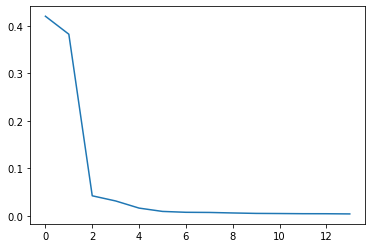

In [33]:
plt.plot(pca01.explained_variance_ratio_)

We have 42% of variance explained by the first PC, and 38% of variance explained by the second PC. Then it goes 4%, 3%, 2%, 1%...

*How do I figure out which points are which stations in the below plot?

<AxesSubplot:>

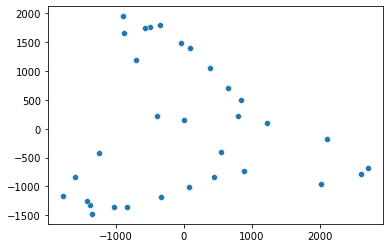

In [34]:
sns.scatterplot(x=station_pc[:,0], y= station_pc[:,1])

Such an interesting shape!

What this means is that the stations don't naturally cluster into a couple types. At least right now it seems that way from this plot.

Below is a plot with hue as the third PC.

In [35]:
# day_pc_investigation

station_pci = pd.DataFrame(data=station_pc[:,[0,1]], index=station_view.index, columns=['PC1','PC2'])

In [36]:
df = station_pci
northbound = [102,203,304,405,506,607,708,809,910,1011,1112,1213,1314,1415,1516,1616]

df['Northbound'] = np.where(df.index.isin(northbound), 1, 0)

In [37]:
df['ID'] = df.index

In [38]:
df['RouteProgress']= np.where(df['Northbound'],
                             np.round(df['ID'],-2)//100,
                             np.round(1700-df['ID'],-2)//100)

<AxesSubplot:>

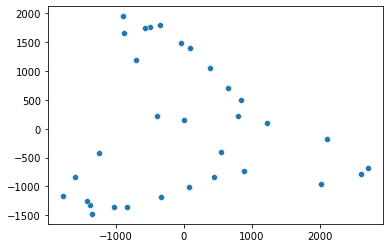

In [42]:
sns.scatterplot(x=station_pc[:,0], y= station_pc[:,1])

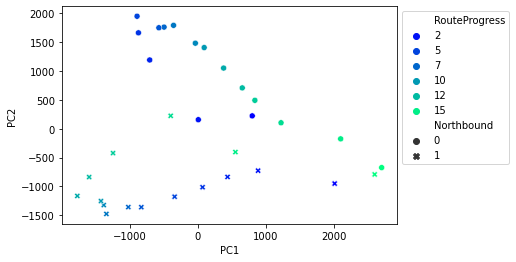

In [43]:
ax = sns.scatterplot(data=station_pci, x='PC1', y='PC2', hue='RouteProgress', style='Northbound', palette='winter')
sns.move_legend(ax, "upper left", bbox_to_anchor = (1,1))

The stations follow the shape mostly in station order but not completely!

#### Now perform PCA on days.

In [44]:
day_view = pw_agg.reset_index().pivot(index='DOY', columns=['Hour','stadir_ID'])

In [45]:
day_view

passwithin                                                         \
Hour              0                                                           
stadir_ID       101  102        201   203        302        304        403    
DOY                                                                           
1          -0.500000  0.0   9.000000   3.5   5.000000   1.333333  19.333333   
2                NaN  NaN   3.000000   NaN        NaN        NaN        NaN   
3           0.666667  NaN   4.333333   NaN   4.333333        NaN   7.750000   
4           5.285714  NaN   8.600000   NaN  10.000000        NaN   5.500000   
5           2.500000  NaN   7.000000   NaN   7.500000  16.000000  12.000000   
..               ...  ...        ...   ...        ...        ...        ...   
361              NaN  NaN  11.500000   NaN  16.000000        NaN  11.000000   
362         4.666667  NaN  12.000000   NaN  11.500000        NaN  13.000000   
363         3.666667  NaN   6.750000   NaN   5.500000  27.000000   4.333333   
364         2.500000  NaN   9.500000   NaN        NaN        NaN        NaN   
365         3.000000  NaN  13.000000  27.0  14.000000  22.000000  14.500000   

                                  ...                                          \
Hour                              ...         23                                
stadir_ID  405        504   506   ...       1312   1314       1413       1415   
DOY                               ...                                           
1          14.0  22.666667  13.0  ...  10.000000  28.20   8.000000  20.333333   
2           NaN        NaN   NaN  ...   7.500000  34.40  10.250000  39.000000   
3           NaN   9.333333  44.0  ...  36.000000  31.75  17.200000  28.000000   
4           NaN   8.333333  34.0  ...  10.000000  42.50  34.000000  43.000000   
5          15.0  10.000000  14.0  ...  24.000000  58.00  22.000000  17.500000   
..          ...        ...   ...  ...        ...    ...        ...        ...   
361         NaN  11.500000   NaN  ...  21.000000  37.00  21.000000  35.000000   
362         NaN  16.000000   NaN  ...  13.000000  39.00   6.000000  25.500000   
363        27.0   9.000000  15.5  ...  22.000000  30.50  11.000000  40.500000   
364         NaN        NaN   NaN  ...        NaN  36.50  17.500000  34.000000   
365        21.0  18.000000  19.0  ...  22.333333  62.50  20.333333  30.333333   

                                                                            
Hour                                                                        
stadir_ID       1514       1516       1615      1616       1110       1211  
DOY                                                                         
1           5.000000   9.333333   3.000000  0.500000        NaN        NaN  
2           5.666667  20.500000   6.666667  2.333333  27.666667  17.000000  
3           9.400000  18.666667   5.250000  2.200000  33.000000  25.000000  
4          14.500000  27.500000   7.000000  6.000000        NaN  15.000000  
5          14.400000  19.500000   6.000000  3.000000  33.000000  28.555556  
..               ...        ...        ...       ...        ...        ...  
361        13.000000  17.500000   5.666667  0.333333  38.500000  28.666667  
362         7.500000   9.666667   5.333333 -0.333333   9.500000   9.000000  
363         6.333333  20.333333   5.000000  2.500000  24.666667  18.333333  
364        11.000000  22.000000   5.000000  2.333333  23.000000  20.500000  
365        19.333333  13.000000  16.666667  1.000000  23.000000  21.000000  

[365 rows x 768 columns]

In [46]:
day_view.isna().sum().sum()

47628

In [47]:
day_view.shape[0] * day_view.shape[1]

280320

About 15% of entries in this matrix are NaN.

In [48]:
# Try filling NaNs with 0
day_view = day_view.fillna(0)
day_view

passwithin                                                         \
Hour              0                                                           
stadir_ID       101  102        201   203        302        304        403    
DOY                                                                           
1          -0.500000  0.0   9.000000   3.5   5.000000   1.333333  19.333333   
2           0.000000  0.0   3.000000   0.0   0.000000   0.000000   0.000000   
3           0.666667  0.0   4.333333   0.0   4.333333   0.000000   7.750000   
4           5.285714  0.0   8.600000   0.0  10.000000   0.000000   5.500000   
5           2.500000  0.0   7.000000   0.0   7.500000  16.000000  12.000000   
..               ...  ...        ...   ...        ...        ...        ...   
361         0.000000  0.0  11.500000   0.0  16.000000   0.000000  11.000000   
362         4.666667  0.0  12.000000   0.0  11.500000   0.000000  13.000000   
363         3.666667  0.0   6.750000   0.0   5.500000  27.000000   4.333333   
364         2.500000  0.0   9.500000   0.0   0.000000   0.000000   0.000000   
365         3.000000  0.0  13.000000  27.0  14.000000  22.000000  14.500000   

                                  ...                                          \
Hour                              ...         23                                
stadir_ID  405        504   506   ...       1312   1314       1413       1415   
DOY                               ...                                           
1          14.0  22.666667  13.0  ...  10.000000  28.20   8.000000  20.333333   
2           0.0   0.000000   0.0  ...   7.500000  34.40  10.250000  39.000000   
3           0.0   9.333333  44.0  ...  36.000000  31.75  17.200000  28.000000   
4           0.0   8.333333  34.0  ...  10.000000  42.50  34.000000  43.000000   
5          15.0  10.000000  14.0  ...  24.000000  58.00  22.000000  17.500000   
..          ...        ...   ...  ...        ...    ...        ...        ...   
361         0.0  11.500000   0.0  ...  21.000000  37.00  21.000000  35.000000   
362         0.0  16.000000   0.0  ...  13.000000  39.00   6.000000  25.500000   
363        27.0   9.000000  15.5  ...  22.000000  30.50  11.000000  40.500000   
364         0.0   0.000000   0.0  ...   0.000000  36.50  17.500000  34.000000   
365        21.0  18.000000  19.0  ...  22.333333  62.50  20.333333  30.333333   

                                                                            
Hour                                                                        
stadir_ID       1514       1516       1615      1616       1110       1211  
DOY                                                                         
1           5.000000   9.333333   3.000000  0.500000   0.000000   0.000000  
2           5.666667  20.500000   6.666667  2.333333  27.666667  17.000000  
3           9.400000  18.666667   5.250000  2.200000  33.000000  25.000000  
4          14.500000  27.500000   7.000000  6.000000   0.000000  15.000000  
5          14.400000  19.500000   6.000000  3.000000  33.000000  28.555556  
..               ...        ...        ...       ...        ...        ...  
361        13.000000  17.500000   5.666667  0.333333  38.500000  28.666667  
362         7.500000   9.666667   5.333333 -0.333333   9.500000   9.000000  
363         6.333333  20.333333   5.000000  2.500000  24.666667  18.333333  
364        11.000000  22.000000   5.000000  2.333333  23.000000  20.500000  
365        19.333333  13.000000  16.666667  1.000000  23.000000  21.000000  

[365 rows x 768 columns]

In [49]:
pca02 = PCA(n_components=0.7, svd_solver='full')

day_pc = pca02.fit_transform(day_view)

C:\Users\augus\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [50]:
#station_pc
pca02.explained_variance_ratio_

array([0.32673617, 0.09220658, 0.05595519, 0.03488235, 0.02621848,
       0.01991014, 0.01727938, 0.01461438, 0.01431709, 0.01355396,
       0.0116944 , 0.01084389, 0.01049458, 0.00953156, 0.00887304,
       0.00873738, 0.00811739, 0.00752609, 0.00741083, 0.00687921])

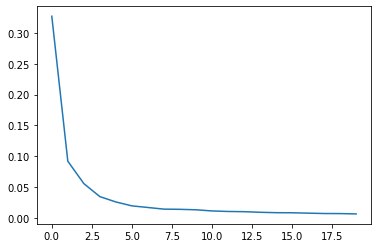

In [51]:
plt.plot(pca02.explained_variance_ratio_)

33% of variance expliained by first PC, then 9% by second PC, then 6%, then 3%. then 3%, 2%, 2%...

I think the natural cutoff is to think of this as essentially 3-dimensional. Maybe 2-dimensional is better though.

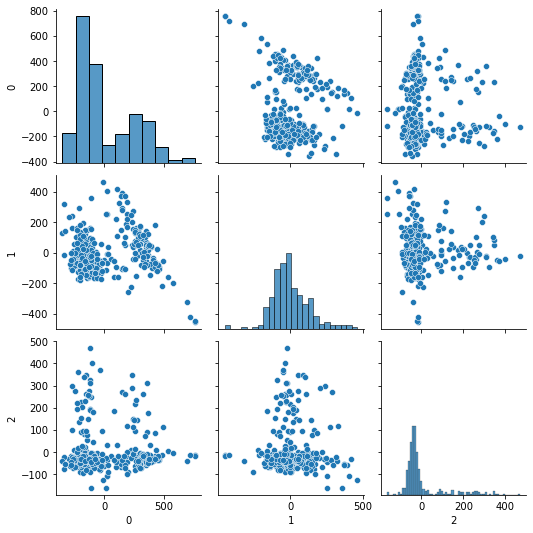

In [53]:
sns.pairplot(pd.DataFrame(day_pc[:,[0,1,2]]))

<AxesSubplot:>

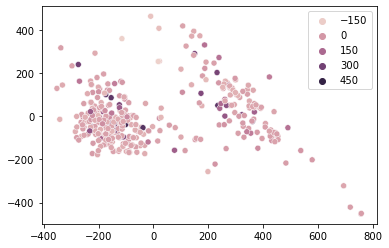

In [54]:
sns.scatterplot(x=day_pc[:,0], y=day_pc[:,1], hue=day_pc[:,2])

<AxesSubplot:>

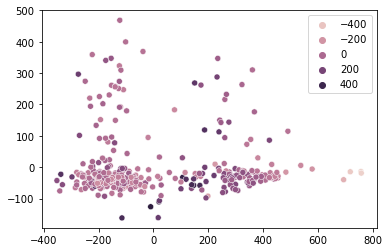

In [55]:
sns.scatterplot(x=day_pc[:,0], y=day_pc[:,2], hue=day_pc[:,1])

<AxesSubplot:>

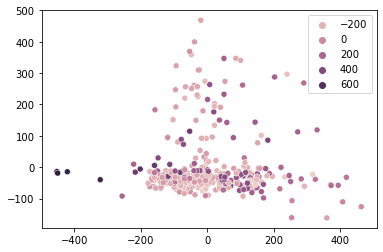

In [56]:
sns.scatterplot(x=day_pc[:,1], y=day_pc[:,2], hue=day_pc[:,0])

Next steps: choose a clustering method that captures the two by-eye-visible clusters; then figure out what aspect of each point makes it belong to a particular cluster versus the other.

### Clustering for Day PCA

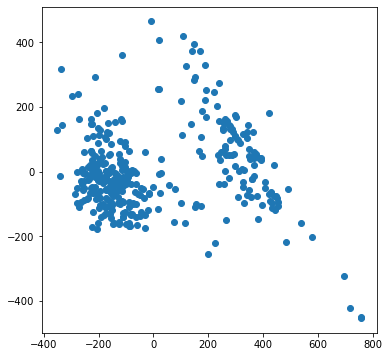

In [57]:
plt.figure(figsize=(6,6))
plt.scatter(day_pc[:,0], day_pc[:,1])

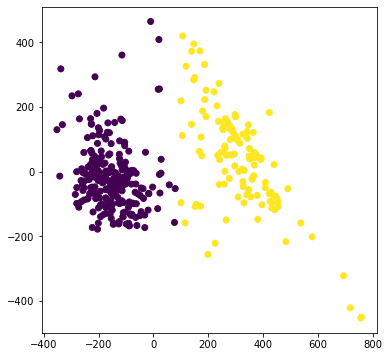

In [58]:
kmeans = KMeans(n_clusters = 2)

labels = kmeans.fit_predict(day_pc[:,[0,1]])

plt.figure(figsize=(6,6))
plt.scatter(day_pc[:,0], day_pc[:,1], c=labels)

In [59]:
std = np.std(day_pc[:,[0,1]])

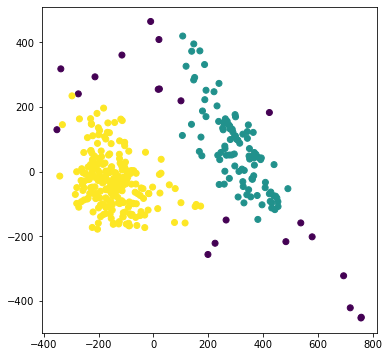

In [60]:
dbscan = DBSCAN(eps = std * 0.4) # 0.4 std was the best I could find
# DBSCAN is really not the best for this problem

labels = dbscan.fit_predict(day_pc[:,[0,1]])

plt.figure(figsize=(6,6))
plt.scatter(day_pc[:,0], day_pc[:,1], c=labels)

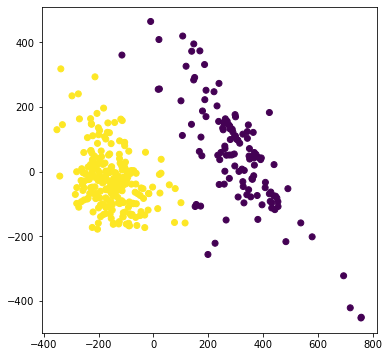

In [61]:
gmm = GaussianMixture(n_components=2, covariance_type='full')

labels = gmm.fit_predict(day_pc[:,[0,1]])

plt.figure(figsize=(6,6))
plt.scatter(day_pc[:,0], day_pc[:,1], c=labels)

In [62]:
dates2019 = pd.date_range("2019-01-01", periods=365, freq="D")

In [63]:
dates2019

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')

In [64]:
# day_pc_investigation

day_pci = pd.DataFrame(data=day_pc[:,[0,1]], index=dates2019, columns=['PC1','PC2'])

In [65]:
day_pci

,PC1,PC2
2019-01-01,490.275316,-53.000003
2019-01-02,-2.964969,-48.123159
2019-01-03,23.803727,-66.486044
2019-01-04,28.246600,37.848837
2019-01-05,365.668706,-13.013612
...,...,...
2019-12-27,167.387871,62.048721
2019-12-28,374.024977,52.856909
2019-12-29,326.077150,115.561285
2019-12-30,115.423423,-159.015621


In [66]:


pd.tseries.offsets.BusinessDay.holidays

<attribute 'holidays' of 'pandas._libs.tslibs.offsets.BusinessMixin' objects>

In [67]:
cal = USFederalHolidayCalendar()

In [68]:
day_pci['Holiday'] = day_pci.index.isin(cal.holidays())

In [69]:
day_pci['DayName'] = day_pci.index.day_name()

In [70]:
day_pci['GMM_Label'] = labels

In [71]:
day_pci

,PC1,PC2,Holiday,DayName,GMM_Label
2019-01-01,490.275316,-53.000003,True,Tuesday,0
2019-01-02,-2.964969,-48.123159,False,Wednesday,1
2019-01-03,23.803727,-66.486044,False,Thursday,1
2019-01-04,28.246600,37.848837,False,Friday,1
2019-01-05,365.668706,-13.013612,False,Saturday,0
...,...,...,...,...,...
2019-12-27,167.387871,62.048721,False,Friday,0
2019-12-28,374.024977,52.856909,False,Saturday,0
2019-12-29,326.077150,115.561285,False,Sunday,0
2019-12-30,115.423423,-159.015621,False,Monday,1


Use seaborn:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

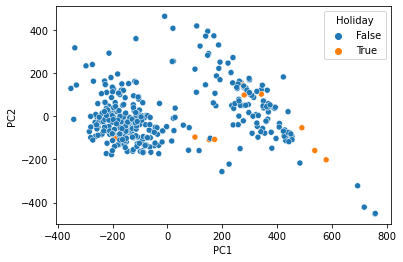

In [74]:
sns.scatterplot(data=day_pci, x='PC1', y='PC2', hue='Holiday')

Holidays mostly appear in the right cluster or on the boundary.

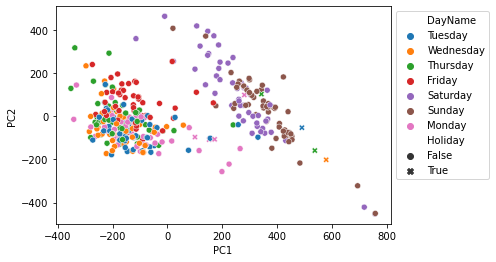

In [75]:
ax = sns.scatterplot(data=day_pci, x='PC1', y='PC2', hue='DayName', style='Holiday')
sns.move_legend(ax, "upper left", bbox_to_anchor = (1,1))

Aha! Pretty much all the Saturdays and Sundays appear to be in the right-hand cluster. (*verify).

Most holidays are in the right-hand cluster as well.

There are also about three Fridays in the right-hand cluster. 

In [76]:
df = day_pci

df[(df['DayName'].isin(['Friday','Monday'])) & (~df['GMM_Label'])].sort_values('DayName')

,PC1,PC2,Holiday,DayName,GMM_Label
2019-07-05,105.547543,111.471194,False,Friday,0
2019-11-29,17.466008,254.112355,False,Friday,0
2019-12-27,167.387871,62.048721,False,Friday,0
2019-01-21,152.113627,-108.153178,True,Monday,0
2019-02-04,264.970150,-149.868202,False,Monday,0
2019-02-11,224.755691,-221.674062,False,Monday,0
2019-02-18,172.099591,-106.888979,True,Monday,0
2019-05-27,275.188895,144.048209,True,Monday,0
2019-09-02,280.278696,98.911586,True,Monday,0
2019-10-21,198.732674,-256.370525,False,Monday,0


Aha! These cluster-0 Fridays are all holiday-like days - July 5th, Black Friday, and Christmas week Friday.

Monday non-holidays are a bit harder to understand. Feb 4 and Feb 11 were snowstorms.

Did some research on Oct 21 and didn't conclude anything. That point was right on the line between the two clusters anyway. Maybe there were enough small things going on to encourage people to take a day off work - day after an NFL game, a film festival, etc.

In [77]:
df = day_pci

df[(df['DayName'].isin(['Saturday','Sunday'])) & (~df['GMM_Label'])].sort_values('DayName')

,PC1,PC2,Holiday,DayName,GMM_Label
2019-01-05,365.668706,-13.013612,False,Saturday,0
2019-04-27,282.412355,130.980811,False,Saturday,0
2019-10-26,717.648944,-421.278815,False,Saturday,0
2019-05-11,234.652593,50.320063,False,Saturday,0
2019-05-18,150.322200,290.727942,False,Saturday,0
...,...,...,...,...,...
2019-05-19,241.848202,36.746006,False,Sunday,0
2019-05-12,360.872002,-24.139998,False,Sunday,0
2019-05-05,368.119173,19.841893,False,Sunday,0
2019-06-16,314.660221,87.505801,False,Sunday,0


Yep, that's every Saturday and Sunday

In [78]:
df = day_pci

df[(df['DayName'].isin(['Tuesday','Wednesday','Thursday'])) & (~df['GMM_Label'])].sort_values('DayName')

,PC1,PC2,Holiday,DayName,GMM_Label
2019-07-04,342.600545,102.644055,True,Thursday,0
2019-11-28,537.283006,-158.818569,True,Thursday,0
2019-12-26,239.744983,-40.055258,False,Thursday,0
2019-01-01,490.275316,-53.000003,True,Tuesday,0
2019-02-12,156.141939,-101.841182,False,Tuesday,0
2019-12-24,330.067116,-96.953177,False,Tuesday,0
2019-12-31,258.133809,-38.985578,False,Tuesday,0
2019-12-25,578.709685,-201.833830,True,Wednesday,0


Feb 12 Snowstorm. Christmas week. That's it.